# Coordinate Pair-Up Map Generator

In [27]:
import math
import random

import cv2
import numpy as np
from matplotlib import pyplot as plt

from helper import evaluate_map, generate_init_map, output_map_file, plot_map

# initialize map
rng_seed = 12345 # ! Seed
map_height = 100
map_width = map_height

init_map_np = generate_init_map(map_height=map_height, map_width=map_width)
rng = np.random.default_rng(rng_seed)

In [28]:
def compute_wall_direction_1(x_coor, y_coor, x_distance, y_distance, map, dir):
    temp_list = []
    if dir == 0: # go horizontal first
        map[ y_coor , x_coor + x_distance : x_coor+1] = 1
        map[ y_coor:y_coor + y_distance+1, x_coor + x_distance] = 1

    elif dir == 1: # go vertical first
        map[ y_coor: y_coor + y_distance+1,x_coor] = 1
        map[ y_coor+ y_distance, x_coor + x_distance : x_coor+1] = 1
    
    elif dir == 2: # go horizontal first
        map[ y_coor, x_coor + x_distance: x_coor+1] = 1
        map[ y_coor + y_distance : y_coor+1, x_coor + x_distance] = 1
         
    elif dir == 3: # go vertical first
        map[ y_coor + y_distance : y_coor+1, x_coor] = 1
        map[y_coor + y_distance, x_coor + x_distance: x_coor+1] = 1
    return map

def compute_wall_direction_2(x_coor, y_coor, x_distance, y_distance, map, dir):
    if dir == 0: # go horizontal first
        map[ y_coor , x_coor:x_coor + x_distance+1] = 1
        map[ y_coor:y_coor + y_distance+1, x_coor + x_distance] = 1

    elif dir == 1: # go vertical first
        map[ y_coor: y_coor + y_distance+1,x_coor] = 1
        map[ y_coor+ y_distance, x_coor: x_coor + x_distance+1] = 1
    
    elif dir == 2: # go horizontal first
        map[ y_coor, x_coor : x_coor+ x_distance+1] = 1
        map[ y_coor + y_distance : y_coor+1, x_coor + x_distance] = 1
         
    elif dir == 3: # go vertical first
        map[ y_coor + y_distance +1 : y_coor, x_coor] = 1
        map[y_coor + y_distance, x_coor: x_coor + x_distance+1] = 1
    return map

def smooth_map(map_np):
    filter = np.array([1, 0, 1])
    filter2 = np.array([[1], [0], [1]])
    filter3 = np.array([[1], [0], [1]])
    for i in range(map_np.shape[0]):
        for j in range(map_np.shape[1]):
            if map_np[i][j] == 0:
                hor_array = map_np[i, j-1:j+2]
                ver_array = map_np[i-1:i+2, j]

                if np.array_equiv(hor_array, filter) or np.array_equiv(ver_array, filter):
                    map_np[i][j] = 1
                # value = np.sum(new_array)
                # if value > 1:
                #     map_np[i][j] = 1
                    # print(new_array,value)
    return map_np

def fill_box(map: np.ndarray):
    map = map.astype(np.uint8)*255
    contours = cv2.findContours(map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    for c in contours:
        cv2.drawContours(map, [c], 0, (255, 255, 255), -1)
    map = map.astype(np.uint8)/255
    return map


In [29]:
# map generation
map_np = init_map_np.copy()
random_size = 60
while True:
    wall_count = rng.integers(200, 250) #generate random wall number
    if wall_count % 2 == 0: # make sure those number is even number
        break

count = 0
x_coordinate = []
y_coordinate = []
wall_coordinate = []
rng.integers(low=1, high=map_height-1, size=(random_size))

#store all wall coordinates in a list
while (count < wall_count):
    wall_coordinate.append((rng.integers(low=1, high=map_width-1),rng.integers(low=1, high=map_height-1)))
    map_np[wall_coordinate[count]] = 1
    count += 1

#sort the coordinates x,y
wall_coordinate = sorted(wall_coordinate, key=lambda k: [k[1], k[0]])
paired_coordinate = []

#find the closest point for each coordinate and make them into pairs
while len(wall_coordinate) > 0:
    first_coordinate = wall_coordinate.pop(0)
    min_coordinate_index = 0
    for count, item in enumerate(wall_coordinate):
        if count == 0:
            continue
        cur_coordinate = wall_coordinate[count]
        cur_coordinate_distance = math.dist(
                    first_coordinate,
                    cur_coordinate)
        if count == 1 or cur_coordinate_distance <= min_coordinate_distance:            
            min_coordinate_distance = cur_coordinate_distance
            min_coordinate_index = count

    paired_coordinate.append(first_coordinate)
    paired_coordinate.append(wall_coordinate[min_coordinate_index])
    wall_coordinate.pop(min_coordinate_index)

paired_coordinate_copy = paired_coordinate.copy()

#compute line between 2 coordinates
while len(paired_coordinate_copy) > 0:
    first_pair = paired_coordinate_copy.pop(0)
    second_pair = paired_coordinate_copy.pop(0)
    x_distance = second_pair[1] - first_pair[1]
    y_distance = second_pair[0] - first_pair[0]
    random_dir = random.randrange(0, 2)
    #for 2 pairs, their position can seperate into 4 quadrants
    '''
    [[quadrants II, quadrants I],
    [quadrants III, quadrants IV]]
    '''
    if x_distance < 0:
        if y_distance > 0:
            #quadrants II
            map_np = compute_wall_direction_1(first_pair[1], first_pair[0], x_distance, y_distance, map_np, random_dir)
        elif y_distance < 0:
            #quadrants III
            map_np = compute_wall_direction_1(first_pair[1], first_pair[0], x_distance, y_distance, map_np, random_dir+2)
        else:
            map_np[first_pair[0],second_pair[1] : first_pair[1]+1] = 1 #just draw line
    elif x_distance > 0:
        if y_distance > 0:
            #quadrants I
            map_np = compute_wall_direction_2(first_pair[1], first_pair[0], x_distance, y_distance, map_np, random_dir)
        elif y_distance < 0:     
            #quadrants IV   
            map_np = compute_wall_direction_2(first_pair[1], first_pair[0], x_distance, y_distance, map_np, random_dir+2)            
        else:
            map_np[first_pair[0],first_pair[1] : second_pair[1]+1] = 1 #just draw line
    else: #if x is in the same line
        if y_distance < 0:
            map_np[second_pair[0] : first_pair[0] +1,first_pair[1]] =1 #just draw line
        else:            
            map_np[first_pair[0] : second_pair[0] +1,first_pair[1]] = 1 #just draw line

count = 0
map_np = smooth_map(map_np) #close up those gap which is only 1 pixel
#fill empty box
for count in range(4):
    if count == 0:
        map_np[0:50,0:map_width] = fill_box(map_np[0:50,0:map_width])
    if count == 1:
        map_np[50:map_height,0:map_width] = fill_box(map_np[50:map_height,0:map_width])
    if count == 2:
        map_np[0:map_height,0:50] = fill_box(map_np[0:map_height,0:50])
    if count == 3:
        map_np[0:map_height,50:map_width] = fill_box(map_np[0:map_height,50:map_width])
#check the whole map (except border) and fill empty box
map_np[1:map_height-1,1:map_np.shape[1]-1] = fill_box(map_np[1:map_height-1,1:map_width-1])
map_np[1:map_height-1,1:map_np.shape[1]-1] = fill_box(map_np[1:map_height-1,1:map_width-1])

In [30]:
# evaluation
avgCrossEntropy = evaluate_map(map_np=map_np)
print(f"Evaluation score is: {avgCrossEntropy:.3f}")


Evaluation score is: 0.868


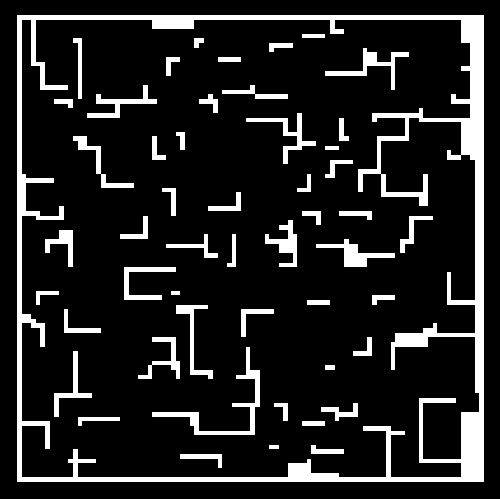

In [31]:
# visualize the map
plot_map(map_np=map_np, map_height=map_height,  map_width=map_width)

In [32]:
# output map
output_map_file(map_np=map_np, file_name=f'CPU_{rng_seed}.txt')
